In [27]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# import tensorflow as tf
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split

In [35]:
data_dir = 'D:/Hamed/Forschungsproject/UNet/BAGLS_4096'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('.png'):
        if not filename.endswith('_seg.png'):
            x.append(os.path.join(data_dir, filename))
        else:
            y.append(os.path.join(data_dir, filename))
            


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [36]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Dataset Sizes:
Training set: 3649 samples
Validation set: 406 samples
Test set: 41 samples


In [104]:
## gen
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, list_lables, batch_size=2, shuffle=True,aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.batch_size = batch_size
        self.list_labels = list_lables
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_lable_paths = [self.list_labels[k] for k in indexes]
        
        # Generate data
        X,y = self.__data_generation(list_IDs_paths,list_lable_paths)

        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_lable_paths):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_lable_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            img_arr = img_arr.convert("L")
            img_arr = img_arr.resize((256, 256))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize((256, 256))
            lbl_arr = np.array(lbl_arr, dtype=np.float32)
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1
            
            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else: 
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images


    def viz(self, x_images,y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)

        # Display original and transformed images side by side
        for i in range(batch_size):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Original image
            axes[0].imshow(x_images[i])
            axes[0].set_title("Original Image")

            # Transformed image
            axes[1].imshow(y_images[i])
            axes[1].set_title("Transformed Image")
            

            plt.show()
            
        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[i])} and for masks {np.shape(y_images[i])}')
        print(f'max value for images is {np.max(x_images[i])} and for masks {np.max(y_images[i])}')
        print(f'min value for images is {np.min(x_images[i])} and for masks {np.min(y_images[i])}')
        print(f'number of unique values in images is {len(np.unique(x_images[i]))} and for masks {np.unique(y_images[i])}')

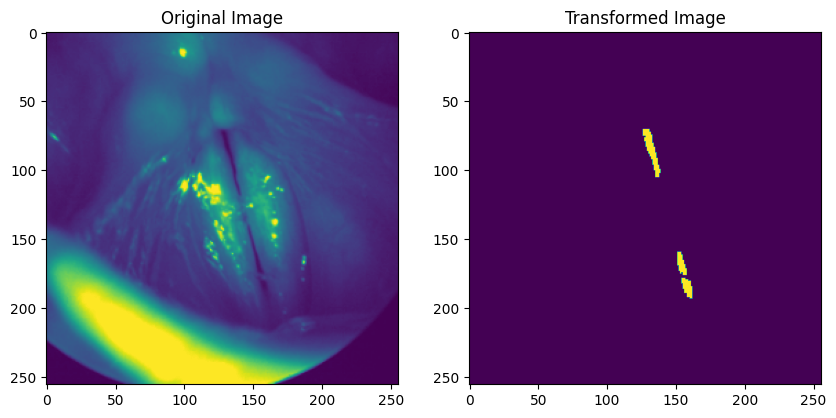

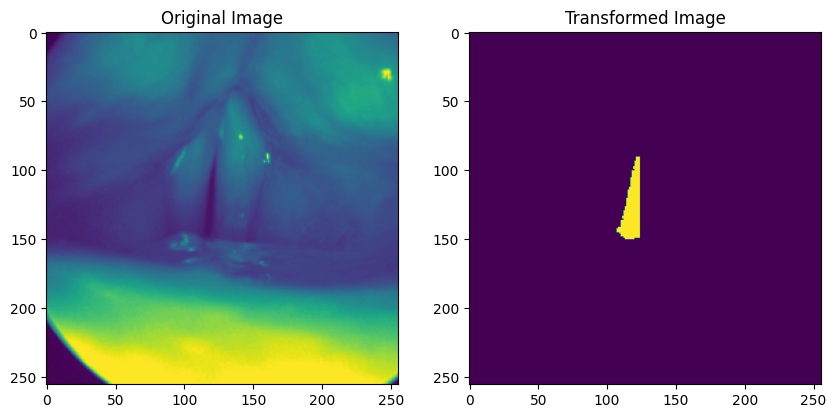

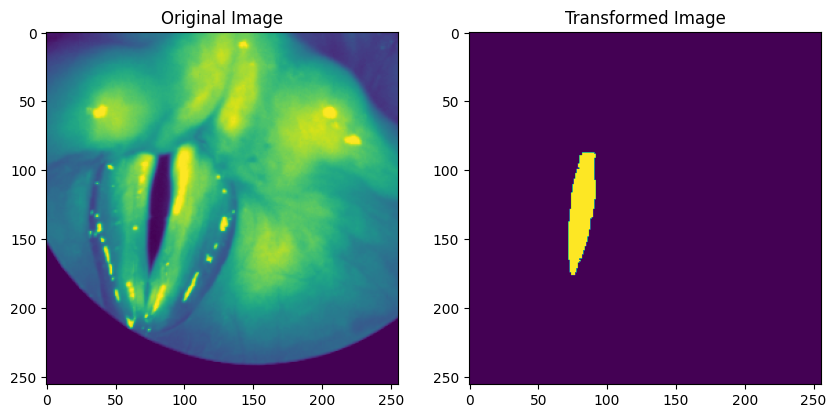

Batch shape (3, 256, 256) and for masks (3, 256, 256)
image shape (256, 256) and for masks (256, 256)
max value for images is 0.9547672867774963 and for masks 1.0
min value for images is 0.0 and for masks 0.0
number of unique values in images is 243 and for masks [0. 1.]


In [42]:
test = DataGenerator(x,y,batch_size=3)
a,b = test.__getitem__(2)
test.viz(a,b)

In [65]:

fil = 4
inputs = Input((256, 256,1))


# Contractive
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

# Expansive
upconv1 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
up6 = UpSampling2D(size = (2,2))(upconv1)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = UpSampling2D(size = (2,2))(upconv2)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = UpSampling2D(size = (2,2))(upconv3)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)


upconv4 = Conv2D(fil*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = UpSampling2D(size = (2,2))(upconv4)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)


conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#model.summary()




In [66]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

In [67]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()


In [68]:
model.compile(optimizer = 'Adam', loss = loss, metrics = [metric])
history = model.fit(DataGenerator(X_train, Y_train, batch_size=32), 
                    epochs=20, 
                    callbacks=earlystop_callback,
                    validation_data=DataGenerator(X_val, Y_val, batch_size=32))

Epoch 1/20
114/114 [==============================] - 18s 148ms/step - loss: 0.9339 - iou_score: 0.0343 - val_loss: 0.9449 - val_iou_score: 0.0283
Epoch 2/20
114/114 [==============================] - 15s 127ms/step - loss: 0.8943 - iou_score: 0.0562 - val_loss: 0.8779 - val_iou_score: 0.0651
Epoch 3/20
114/114 [==============================] - 16s 139ms/step - loss: 0.7770 - iou_score: 0.1277 - val_loss: 0.6390 - val_iou_score: 0.2214
Epoch 4/20
114/114 [==============================] - 15s 134ms/step - loss: 0.4847 - iou_score: 0.3546 - val_loss: 0.1759 - val_iou_score: 0.7019
Epoch 5/20
114/114 [==============================] - 17s 145ms/step - loss: 0.2717 - iou_score: 0.5785 - val_loss: 0.3559 - val_iou_score: 0.4780
Epoch 6/20
114/114 [==============================] - 16s 142ms/step - loss: 0.2029 - iou_score: 0.6703 - val_loss: 0.1170 - val_iou_score: 0.7912
Epoch 7/20
114/114 [==============================] - 16s 135ms/step - loss: 0.1741 - iou_score: 0.7115 - val_loss: 0.

In [56]:
#history.history

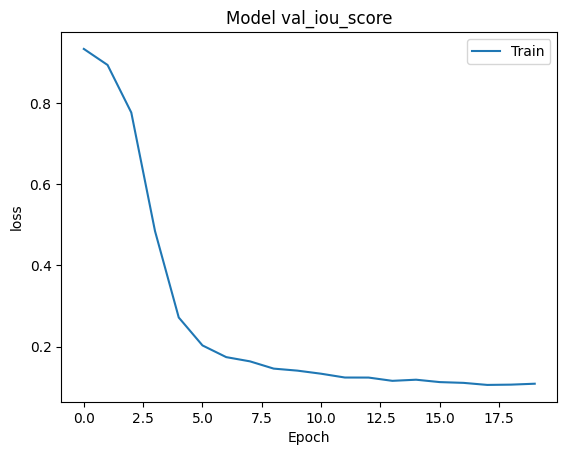

In [69]:
#how was the network on each epoch?

plt.plot(history.history['loss'])
plt.title('Model val_iou_score')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [106]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=False)
score = model.evaluate(DataGen)


1/1 [==============================] - 0s 235ms/step - loss: 0.1743 - iou_score: 0.7032


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


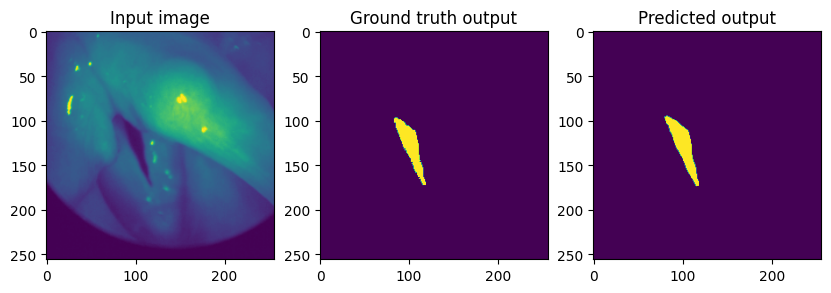

In [114]:
# Choose an index i to plot

test = DataGenerator(x,y,batch_size=1,aug=False)
img,mask = test.__getitem__(2)
y_pred = model.predict(img)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(img[0])
axs[0].set_title('Input image')

# Plot the ground truth output in the second subplot
axs[1].imshow(mask[0])
axs[1].set_title('Ground truth output')

# Plot the predicted output in the third subplot
axs[2].imshow(y_pred[0])
axs[2].set_title('Predicted output')

# Show the figure
plt.show()